## Satellite imagery usage
I'm just investigating how to pull images from the Sentinel 2 satellite, querying a specific place and time. I used the API's provided example: https://sentinelhub-py.readthedocs.io/en/latest/examples/data_search.html#Sentinel-Hub-Catalog-API

In [1]:
# Project dependencies
# ! pip install sentinelsat
# ! pip install sentinelhub --upgrade

In [2]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'ec1e85c6-0718-4b23-8bfb-6ecd88cc5599'
config.sh_client_secret = 'Gha8Bk_nYHb>yzoo.ShpXO8ll<I0Ctejf/yE2)3J'
config.save()

In [3]:
from sentinelhub import SentinelHubCatalog


catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'stac_version': '0.9.0',
 'stac_extensions': [],
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v0.9.0 implementation by Sentinel Hub',
 'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/',
   'rel': 'self'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/conformance',
   'rel': 'conformance'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/search',
   'rel': 'search'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections',
   'rel': 'data'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-1-grd',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l2a',
   'rel': 'child'}]}

In [4]:
%matplotlib inline

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import SHConfig, BBox, CRS, DataCollection,\
    SentinelHubRequest, filter_times, bbox_to_dimensions, \
    MimeType, SentinelHubDownloadClient


In [5]:
caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)
time_interval = '2021-08-10', '2021-8-19'

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=caspian_sea_bbox,
    time=time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }

)

results = list(search_iterator)
print('Total number of results:', len(results))

results

Total number of results: 13


[{'id': 'S2B_MSIL2A_20210818T072619_N0301_R049_T39TVK_20210818T091053',
  'properties': {'datetime': '2021-08-18T07:37:22Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2B_MSIL2A_20210818T072619_N0301_R049_T39TWK_20210818T091053',
  'properties': {'datetime': '2021-08-18T07:37:19Z', 'eo:cloud_cover': 1.01}},
 {'id': 'S2B_MSIL2A_20210818T072619_N0301_R049_T39TVL_20210818T091053',
  'properties': {'datetime': '2021-08-18T07:37:08Z', 'eo:cloud_cover': 3.43}},
 {'id': 'S2B_MSIL2A_20210818T072619_N0301_R049_T39TWL_20210818T091053',
  'properties': {'datetime': '2021-08-18T07:37:04Z', 'eo:cloud_cover': 3.75}},
 {'id': 'S2A_MSIL2A_20210816T073611_N0301_R092_T39TWK_20210816T094843',
  'properties': {'datetime': '2021-08-16T07:47:15Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2A_MSIL2A_20210816T073611_N0301_R092_T39TVL_20210816T094843',
  'properties': {'datetime': '2021-08-16T07:47:08Z', 'eo:cloud_cover': 2.96}},
 {'id': 'S2A_MSIL2A_20210816T073611_N0301_R092_T39TWL_20210816T094843',
  'properties': {'dateti

In [6]:
time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2021, 8, 11, 7, 47, 6, tzinfo=tzutc()),
 datetime.datetime(2021, 8, 13, 7, 37, 7, tzinfo=tzutc()),
 datetime.datetime(2021, 8, 16, 7, 47, 3, tzinfo=tzutc()),
 datetime.datetime(2021, 8, 18, 7, 37, 4, tzinfo=tzutc())]

In [7]:
false_color_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B04", "B08"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08, sample.B04, sample.B03];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(timestamp - time_difference, timestamp + time_difference)
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=caspian_sea_bbox,
        size=bbox_to_dimensions(caspian_sea_bbox, 100),
        config=config
    )
    process_requests.append(request)

In [8]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

CPU times: user 169 ms, sys: 42.5 ms, total: 212 ms
Wall time: 3.74 s


(567, 861, 3)

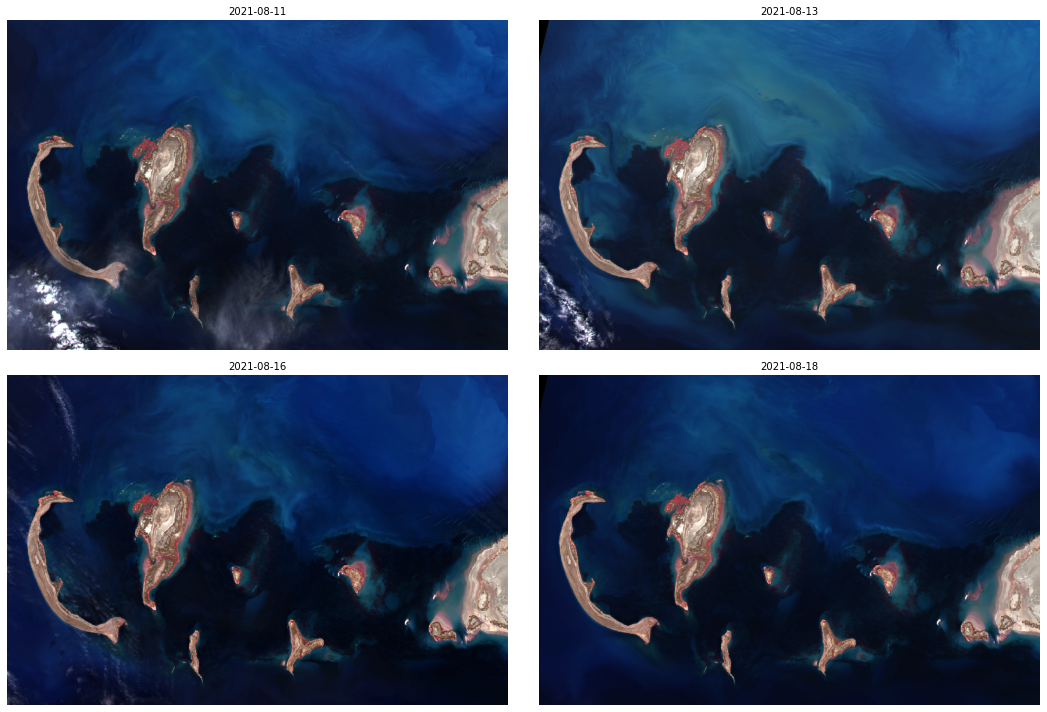

In [9]:
ncols, nrows = 2, 2

fig, axis = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 10),
    subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

## Importing wildfire data

In [10]:
# ! pip install sqlite3

In [11]:
import sqlite3
import pandas as pd

connection = sqlite3.connect("data/FPA_FOD_20170508.sqlite")

In [12]:
fires_df = pd.read_sql_query("""
    SELECT * 
    FROM Fires""", connection)

In [13]:
fires_df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [14]:
fires_columns = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE',\
                'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR']
fires_df[fires_columns]

,OBJECTID,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
0,1,2005,33,0.10,40.036944,-121.005833,9.0,Miscellaneous
1,2,2004,133,0.25,38.933056,-120.404444,1.0,Lightning
2,3,2004,152,0.10,38.984167,-120.735556,5.0,Debris Burning
3,4,2004,180,0.10,38.559167,-119.913333,1.0,Lightning
4,5,2004,180,0.10,38.559167,-119.933056,1.0,Lightning
...,...,...,...,...,...,...,...,...
1880460,1880461,2015,269,0.01,40.481637,-122.389375,13.0,Missing/Undefined
1880461,1880462,2015,278,0.20,37.617619,-120.938570,9.0,Miscellaneous
1880462,1880463,2015,122,0.10,37.617619,-120.938570,13.0,Missing/Undefined
1880463,1880464,2015,287,2.00,37.672235,-120.898356,13.0,Missing/Undefined


## Finding images preceding a random fire

In [15]:
fires_df_recent = fires_df[fires_df['FIRE_YEAR'] >= 2015]
fires_df_recent = fires_df_recent[fires_df['DISCOVERY_DOY'] >= 188]
fires_df_recent
#len(fires_df_recent['DISCOVERY_DOY'])

<ipython-input-15-532262d64a80>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fires_df_recent = fires_df_recent[fires_df['DISCOVERY_DOY'] >= 188]


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
1789011,1789012,300200261,FS-6341424,FED,FS-FIRESTAT,FS,USMTBDF,Beaverhead/Deerlodge National Forest,0102,Beaverhead/Deerlodge National Forest,...,A,45.934167,-113.020833,5.0,USFS,MT,001,001,Beaverhead,b'\x00\x01\xad\x10\x00\x00\x10\xc1QUUA\\\xc0\x...
1789012,1789013,300200262,FS-6341435,FED,FS-FIRESTAT,FS,USMTBDF,Beaverhead/Deerlodge National Forest,0102,Beaverhead/Deerlodge National Forest,...,G,45.515278,-113.245278,5.0,USFS,MT,001,001,Beaverhead,b'\x00\x01\xad\x10\x00\x00D\xe2\x92\xa1\xb2O\\...
1789013,1789014,300200263,FS-6332443,FED,FS-FIRESTAT,FS,USMTBDF,Beaverhead/Deerlodge National Forest,0102,Beaverhead/Deerlodge National Forest,...,A,45.727222,-112.943889,5.0,USFS,MT,001,001,Beaverhead,b'\x00\x01\xad\x10\x00\x00\xe4f\xf2\xach<\\\xc...
1789014,1789015,300200264,FS-6341423,FED,FS-FIRESTAT,FS,USMTBDF,Beaverhead/Deerlodge National Forest,0102,Beaverhead/Deerlodge National Forest,...,A,45.455556,-113.749722,5.0,USFS,MT,001,001,Beaverhead,b'\x00\x01\xad\x10\x00\x00\x00\xff\xe7r\xfbo\\...
1789015,1789016,300200265,FS-6351412,FED,FS-FIRESTAT,FS,USMTBDF,Beaverhead/Deerlodge National Forest,0102,Beaverhead/Deerlodge National Forest,...,A,44.416667,-112.843333,5.0,USFS,MT,001,001,Beaverhead,"b'\x00\x01\xad\x10\x00\x00\x80\xfe[,\xf95\\\xc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880457,1880458,300348354,2015CAIRS28234594,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,B,40.588583,-123.069617,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\xb8\x8f\xdc\x9at\xc...
1880458,1880459,300348361,2015CAIRS27957490,NONFED,ST-CACDF,ST/C&L,USCAHUU,Humboldt-Del Norte Unit,CAHUU,Humboldt-Del Norte Unit,...,B,40.244833,-123.544167,15.0,UNDEFINED FEDERAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\xfc#\xd3\xa1\xd3\xe...
1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...


In [16]:
import random
import numpy as np
from datetime import datetime

fire = fires_df_recent[fires_df_recent['OBJECTID'] == random.choice(fires_df_recent['OBJECTID'].tolist())]
fire

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
1871666,1871667,300308009,SFO-2015CACDFSKU008519,NONFED,ST-NASF,ST/C&L,USCASKU,Siskiyou Unit,CASKU,Siskiyou Unit,...,A,41.352767,-122.3681,14.0,MISSING/NOT SPECIFIED,CA,SISKIYOU,093,Siskiyou,"b""\x00\x01\xad\x10\x00\x00\x14jM\xf3\x8e\x97^\..."


In [17]:
def get_bbox(fire):
    longitude = fire['LONGITUDE'].values[0]
    latitude = fire['LATITUDE'].values[0]
    area_acres = fire['FIRE_SIZE'].values[0]
    area_kmsqs = area_acres / 247.105
    d_kms = np.sqrt(area_kmsqs)
    d_long = d_kms / 111.111
    d_lat = d_kms / (111.111 * np.cos(longitude * (np.pi / 180)))
    bbox = [longitude - (d_long/2), latitude - (d_lat/2), \
            longitude + (d_long/2), latitude + (d_lat/2)]
    return bbox

def get_time_interval(fire):
    doy_f = fire['DISCOVERY_DOY'].values[0] + 100
    doy_i = fire['DISCOVERY_DOY'].values[0] - 30 
    year_f = fire['FIRE_YEAR'].values[0]
    year_i = year_f
    if doy_i < 0:
        doy_i = 365 + doy_i
        year_i -= 1
    return [get_date(doy_i, year_i), get_date(doy_f, year_f)]

def get_date(doy, year):
    doy = str(doy)
    year = str(year)
    # adjusting day num
    doy.rjust(3 + len(doy), '0')
    # converting to date
    return datetime.strptime(year + "-" + doy, "%Y-%j").strftime("%Y-%m-%d")


fire_bbox = BBox(get_bbox(fire), crs=CRS.WGS84)
print(fire_bbox)
fire_time_interval = get_time_interval(fire)
print(fire_time_interval)

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=fire_bbox,
    time=fire_time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }

)

results = list(search_iterator)
print('Total number of results:', len(results))

results

-122.36812862675897,41.35271352768323,-122.36807137324102,41.35282047231677


ValueError: unconverted data remains: 1

Ok so there's actually no overlap between the dataset of wildfires and available Sentinel imagery.

## Alternative wildfire dataset

National Intragency Fire Center:
- 2000-2018: https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018/about
- 2019: https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-2019/about

In [39]:
# ! pip install geopandas
# ! pip install fiona
# ! pip install folium
# ! pip install mapclassify
# ! pip install contextily

In [40]:
import fiona 
import geopandas as gpd
import pandas as pd
import contextily as cx

path_to_data = "data/HistoricPerimeters2000-2018.gdb"
pre_2018_gdf = gpd.read_file(path_to_data)

In [41]:
pre_2018_gdf.columns

Index(['agency', 'comments', 'mapmethod', 'datecurrent',
       'uniquefireidentifier', 'fireyear', 'incidentname', 'pooownerunit',
       'perimeterdatetime', 'gisacres', 'complexname', 'firecode',
       'complexparentirwinid', 'pooresponsibleunit', 'state', 'inciwebid',
       'localincidentidentifier', 'irwinid', 'incomplex', 'complexfirecode',
       'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [42]:
pre_2018_gdf = pre_2018_gdf[pre_2018_gdf['fireyear'] > 2017]

In [43]:
path_to_data = "data/HistoricPerimeters2019.gdb"
post_2018_gdf = gpd.read_file(path_to_data)

In [44]:
shared_columns = [c for c in pre_2018_gdf if c in post_2018_gdf]
fires_gdf = pd.concat([pre_2018_gdf[shared_columns], post_2018_gdf[shared_columns]])

In [45]:
fires_gdf = fires_gdf.to_crs('NAD83')
fires_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [46]:
fires_gdf['centroid'] = fires_gdf.centroid
fires_gdf["area"] = fires_gdf.area
# fires_gdf = fires_gdf.set_geometry("centroid")
# fires_gdf.plot("area", legend=True)

<ipython-input-46-37a231241826>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fires_gdf['centroid'] = fires_gdf.centroid
<ipython-input-46-37a231241826>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fires_gdf["area"] = fires_gdf.area


In [47]:
fire = fires_gdf.iloc[[1052]]
fire

,agency,comments,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,perimeterdatetime,gisacres,...,inciwebid,localincidentidentifier,irwinid,incomplex,complexfirecode,SHAPE_Length,SHAPE_Area,geometry,centroid,area
3774,USFS,WFDSS,Mixed Methods,2018-12-21T00:00:00+00:00,2018-COSJF-000930,2018,Plateau,COSJF,2018-08-15T20:00:00+00:00,18923.537847,...,6015,000930,{0CEDB469-D049-4704-B471-B363D43543E4},N,None,1.085578,0.007815,"MULTIPOLYGON (((-108.52438 37.55103, -108.5242...",POINT (-108.46661 37.61831),0.007815


In [70]:
import folium

m = fire.explore("area", legend=False)
folium.TileLayer('Stamen Terrain', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m

/Users/beccaroskill/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


In [60]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'ec1e85c6-0718-4b23-8bfb-6ecd88cc5599'
config.sh_client_secret = 'Gha8Bk_nYHb>yzoo.ShpXO8ll<I0Ctejf/yE2)3J'
config.save()

In [29]:
from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)
catalog.get_info()

{'stac_version': '0.9.0',
 'stac_extensions': [],
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v0.9.0 implementation by Sentinel Hub',
 'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/',
   'rel': 'self'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/conformance',
   'rel': 'conformance'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/search',
   'rel': 'search'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections',
   'rel': 'data'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-1-grd',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l2a',
   'rel': 'child'}]}

In [30]:
%matplotlib inline

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import SHConfig, BBox, CRS, DataCollection,\
    SentinelHubRequest, filter_times, bbox_to_dimensions, \
    MimeType, SentinelHubDownloadClient


In [31]:
fire = fire.to_crs('EPSG:4326')
fire.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
from datetime import datetime, timedelta

def get_bbox(fire):
    longitude = fire['centroid'].x.values[0]
    latitude = fire['centroid'].y.values[0]
    area_acres = fire['gisacres'].values[0]
    area_kmsqs = area_acres / 247.105
    d_kms = np.sqrt(area_kmsqs)
    d_long = d_kms / 111.111
    d_lat = d_kms / (111.111 * np.cos(longitude * (np.pi / 180)))
    bbox = [longitude - d_long, latitude - d_lat/4, \
            longitude + d_long, latitude + d_lat/4]
    return bbox

def get_time_interval(fire):
    datestr_f = fire['perimeterdatetime'].values[0][:10] 
    date_f = datetime.strptime(datestr_f, "%Y-%m-%d")
    datestr_f = fire['perimeterdatetime'].values[0][:10] 
    date_f = datetime.strptime(datestr_f, "%Y-%m-%d")
    delta = timedelta(14)
    date_i = date_f - delta
    datestr_i = date_i.strftime("%Y-%m-%d")
    return [datestr_i, datestr_f]


fire_bbox = BBox(get_bbox(fire), crs=CRS.WGS84)
print(fire_bbox)
fire_time_interval = get_time_interval(fire)
print(fire_time_interval)

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=fire_bbox,
    time=fire_time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }

)

results = list(search_iterator)
print('Total number of results:', len(results))

results

-108.5453655171012,37.55614515163628,-108.38784637443808,37.68046891262092
['2018-08-01', '2018-08-15']
Total number of results: 7


[{'id': 'S2B_MSIL2A_20180813T175909_N0001_R041_T13SBB_20200308T212427',
  'properties': {'datetime': '2018-08-13T18:11:29Z', 'eo:cloud_cover': 0.6}},
 {'id': 'S2B_MSIL2A_20180813T175909_N0001_R041_T12SYG_20200309T191325',
  'properties': {'datetime': '2018-08-13T18:11:29Z', 'eo:cloud_cover': 0.52}},
 {'id': 'S2B_MSIL2A_20180813T175909_N0001_R041_T12SYG_20200921T095927',
  'properties': {'datetime': '2018-08-13T18:11:29Z', 'eo:cloud_cover': 0.52}},
 {'id': 'S2A_MSIL2A_20180808T175911_N0001_R041_T12SYG_20200310T041314',
  'properties': {'datetime': '2018-08-08T18:11:52Z', 'eo:cloud_cover': 2.57}},
 {'id': 'S2A_MSIL2A_20180808T175911_N0001_R041_T13SBB_20200920T234831',
  'properties': {'datetime': '2018-08-08T18:11:52Z', 'eo:cloud_cover': 2.08}},
 {'id': 'S2A_MSIL2A_20180808T175911_N0001_R041_T12SYG_20200920T233719',
  'properties': {'datetime': '2018-08-08T18:11:52Z', 'eo:cloud_cover': 2.57}},
 {'id': 'S2A_MSIL2A_20180808T175911_N0001_R041_T13SBB_20200310T011918',
  'properties': {'datet

In [33]:
time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2018, 8, 8, 18, 11, 52, tzinfo=tzutc()),
 datetime.datetime(2018, 8, 13, 18, 11, 29, tzinfo=tzutc())]

In [34]:
false_color_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(timestamp - time_difference, timestamp + time_difference)
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=fire_bbox,
        size=bbox_to_dimensions(fire_bbox, 100),
        config=config
    )
    process_requests.append(request)

In [35]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

CPU times: user 45 ms, sys: 9.95 ms, total: 55 ms
Wall time: 1.19 s


(142, 135, 3)

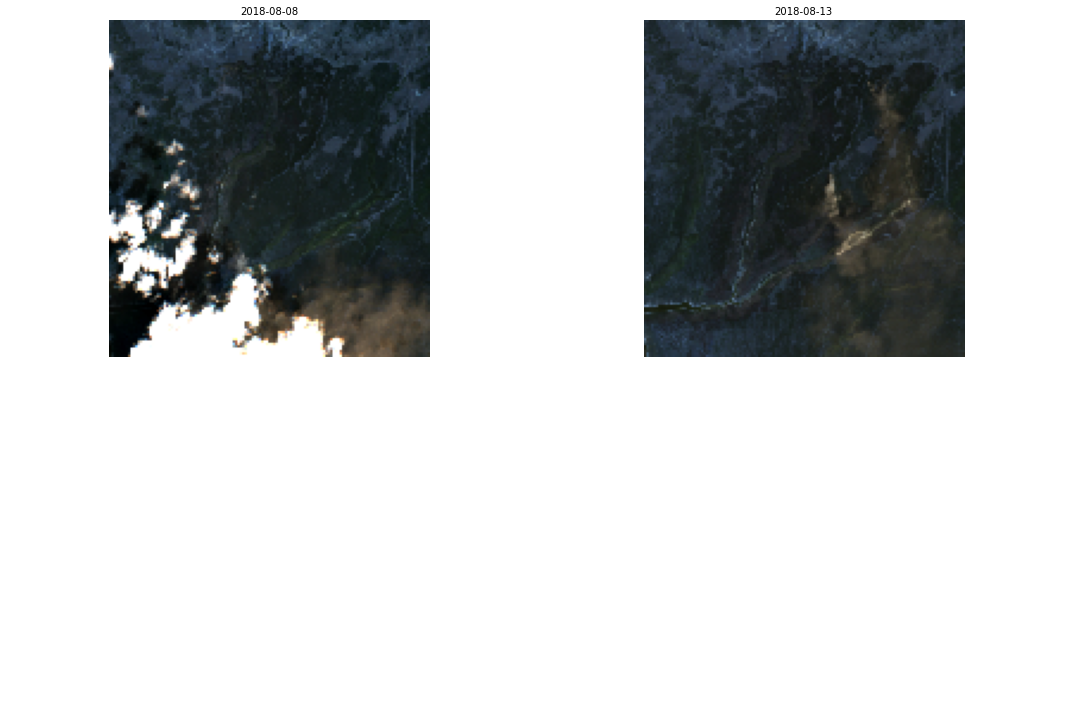

In [36]:
ncols, nrows = 2, 2

fig, axis = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 10),
    subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

I confirmed by looking at Google satellite imagery that this is indeed the same location as the geometry mapped above :)